<a href="https://colab.research.google.com/github/Vegavalley/oxford-iiit-pet-unet/blob/main/Oxford3_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки и диск

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical,Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, Model
from keras import regularizers,losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, GlobalAveragePooling2D, Dense,SeparableConv2D
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from collections import Counter
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import preprocessing

from tqdm import tqdm

from tensorflow.keras.callbacks import LambdaCallback, LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Датасет

## Проверка распределения

In [ ]:


# Загрузка датасета версии 4.*.*
ds, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])
train_ds, val_ds, test_ds = ds

# Функция для извлечения масок
def extract_mask(data):
    mask = data['segmentation_mask']
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)
    return mask

train_ds_masks = train_ds.map(extract_mask, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_masks = val_ds.map(extract_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_masks = test_ds.map(extract_mask, num_parallel_calls=tf.data.AUTOTUNE)

# Подсчёт пикселей по классам
def count_class_pixels(dataset, split_name):
    class_counts = {0: 0, 1: 0, 2: 0}  # Фон, Животное, Граница
    total_pixels = 0
    num_images = 0

    for mask in dataset:
        mask_np = mask.numpy()
        # Нормализация: [1, 2, 3] → [0, 1, 2]
        mask_np = mask_np - 1  # Простой сдвиг
        unique, counts = np.unique(mask_np, return_counts=True)
        for value, count in zip(unique, counts):
            if value in class_counts:
                class_counts[value] += count
            else:
                print(f"Предупреждение: найдено неожиданное значение {value} в {split_name}")
        total_pixels += mask_np.size
        num_images += 1

    # Проценты
    class_percentages = {k: (v / total_pixels * 100) if total_pixels > 0 else 0 for k, v in class_counts.items()}

    print(f"\nСтатистика для {split_name} (изображений: {num_images}):")
    print(f"Всего пикселей: {total_pixels}")
    for cls, count in class_counts.items():
        print(f"Класс {cls} ({['Фон', 'Животное', 'Граница'][cls]}): {count} пикселей, {class_percentages[cls]:.2f}%")

    return class_counts, class_percentages

# Подсчёт
train_counts, train_percentages = count_class_pixels(train_ds_masks, "Train")
val_counts, val_percentages = count_class_pixels(val_ds_masks, "Validation")
test_counts, test_percentages = count_class_pixels(test_ds_masks, "Test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.0YX9HZ_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.0YX9HZ_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.

Статистика для Train (изображений: 2944):
Всего пикселей: 508908566
Класс 0 (Фон): 147295464 пикселей, 28.94%
Класс 1 (Животное): 306199385 пикселей, 60.17%
Класс 2 (Граница): 55413717 пикселей, 10.89%

Статистика для Validation (изображений: 736):
Всего пикселей: 123882969
Класс 0 (Фон): 37268402 пикселей, 30.08%
Класс 1 (Животное): 72724971 пикселей, 58.70%
Класс 2 (Граница): 13889596 пикселей, 11.21%

Статистика для Test (изображений: 3669):
Всего пикселей: 654813722
Класс 0 (Фон): 195486940 пикселей, 29.85%
Класс 1 (Животное): 379548313 пикселей, 57.96%
Класс 2 (Граница): 79778469 пикселей, 12.18%


## Загрузка

In [ ]:
# Загрузка датасета
ds, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])
train_ds, val_ds, test_ds = ds

# Предобработка
def preprocess(data, input_size=(128, 128)):
    image = data['image']
    mask = data['segmentation_mask']
    image = tf.image.resize(image, input_size, method='bilinear')
    mask = tf.image.resize(mask, input_size, method='nearest')
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1  # [1, 2, 3] → [0, 1, 2]
    mask = tf.clip_by_value(mask, 0, 2)
    mask = tf.squeeze(mask, axis=-1)
    return image, mask

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Проверка
for image, mask in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print("Image min/max:", tf.reduce_min(image), tf.reduce_max(image))
    print("Mask unique values:", tf.unique(tf.reshape(mask, [-1]))[0])

Image shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128)
Image min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Mask unique values: tf.Tensor([1 2 0], shape=(3,), dtype=int32)


#Модель

## Простой Unet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

def create_unet_with_cifar10_weights(input_shape=(128, 128, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Энкодер (аналог CIFAR-10)
    c1 = layers.Conv2D(128, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(128, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # (64, 64, 128)
    p1 = layers.Dropout(0.2)(p1)

    c2 = layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # (32, 32, 256)
    p2 = layers.Dropout(0.4)(p2)

    c3 = layers.Conv2D(512, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(512, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # (16, 16, 512)
    p3 = layers.Dropout(0.4)(p3)

    c4 = layers.Conv2D(1024, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(1024, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)  # (8, 8, 1024) — исправлено, добавлен пулинг
    p4 = layers.Dropout(0.4)(p4)

    # Бутылочное горлышко
    c5 = layers.Conv2D(2048, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(2048, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c5)
    c5 = layers.Dropout(0.5)(c5)

    # Декодер
    u6 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c5)  # (16, 16, 1024)
    u6 = layers.Concatenate()([u6, c4])  # c4: (16, 16, 1024)
    c6 = layers.Conv2D(1024, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(1024, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c6)
    c6 = layers.Dropout(0.4)(c6)

    u7 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)  # (32, 32, 512)
    u7 = layers.Concatenate()([u7, c3])  # c3: (32, 32, 512)
    c7 = layers.Conv2D(512, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(512, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c7)
    c7 = layers.Dropout(0.4)(c7)

    u8 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)  # (64, 64, 256)
    u8 = layers.Concatenate()([u8, c2])  # c2: (64, 64, 256)
    c8 = layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c8)
    c8 = layers.Dropout(0.4)(c8)

    u9 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)  # (128, 128, 128)
    u9 = layers.Concatenate()([u9, c1])  # c1: (128, 128, 128)
    c9 = layers.Conv2D(128, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(128, (3, 3), activation='swish', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(2e-4))(c9)
    c9 = layers.Dropout(0.2)(c9)

    # Выходной слой
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Создание модели
model = create_unet_with_cifar10_weights(input_shape=(128, 128, 3), num_classes=3)

# Загрузка весов CIFAR-10
cifar10_model = tf.keras.models.load_model('/content/drive/MyDrive/oxford_pet/best_model_finetuned_3.keras')

# Перенос весов в энкодер
for layer_new, layer_old in zip(model.layers[1:16], cifar10_model.layers[0:12]):  # Учтём больше слоёв
    if 'conv2d' in layer_new.name or 'batch_normalization' in layer_new.name:
        try:
            layer_new.set_weights(layer_old.get_weights())
            layer_new.trainable = False  # Замораживаем энкодер
        except ValueError as e:
            print(f"Ошибка при переносе весов для слоя {layer_new.name}: {e}")

# Компиляция
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

# Проверка переноса весов
print("Первые веса CIFAR-10:", cifar10_model.layers[0].get_weights()[0][0, 0, 0, :5])
print("Первые веса U-Net:", model.layers[1].get_weights()[0][0, 0, 0, :5])

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      3,584 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    295,168 │ dropout_9[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ dropout_10[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16, 16,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ dropout_11[0][0]

 Total params: 124,133,507 (473.53 MB)

 Trainable params: 121,903,363 (465.02 MB)

 Non-trainable params: 2,230,144 (8.51 MB)

Первые веса CIFAR-10: [ 0.23173745 -0.27211586 -0.29394513  0.00244379  0.259385  ]
Первые веса U-Net: [ 0.23173745 -0.27211586 -0.29394513  0.00244379  0.259385  ]


### Обучение

In [ ]:
"""
# Компиляция
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
"""
# Callback’ы
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/oxford_pet/best_unet_oxford_pet_v1.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Обучение
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

# Сохранение
model.save('/content/drive/MyDrive/oxford_pet/unet_oxford_pet_full_v1.keras')
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/oxford_pet/unet_oxford_pet_history_v1.csv', index=False)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.7138 - loss: 4.6568 - val_accuracy: 0.8390 - val_loss: 3.6294 - learning_rate: 1.0000e-04
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8487 - loss: 3.4046 - val_accuracy: 0.8508 - val_loss: 2.9003 - learning_rate: 1.0000e-04
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8719 - loss: 2.6866 - val_accuracy: 0.8565 - val_loss: 2.3884 - learning_rate: 1.0000e-04
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8824 - loss: 2.1874 - val_accuracy: 0.8443 - val_loss: 2.0192 - learning_rate: 1.0000e-04
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8845 - loss: 1.8449 - val_accuracy: 0.8135 - val_loss: 1.9227 - learning_rate: 1.0000e-04
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8914 - loss: 1.5783 - val_accuracy: 0.8647 - val_loss: 1.5353 - learning_rate: 1.0000e-04
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9016 

115/115 ━━━━━━━━━━━━━━━━━━━━ 112s 744ms/step
Test IoU: 0.7404537


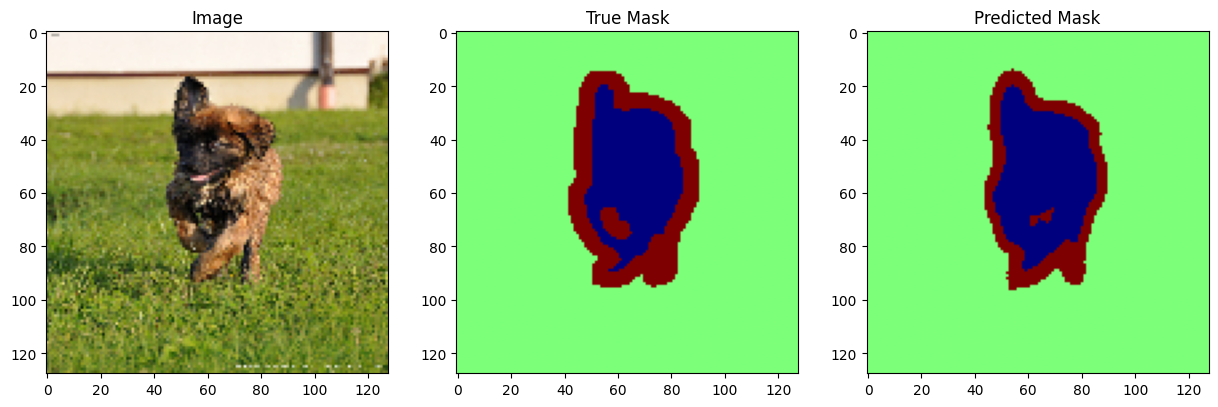

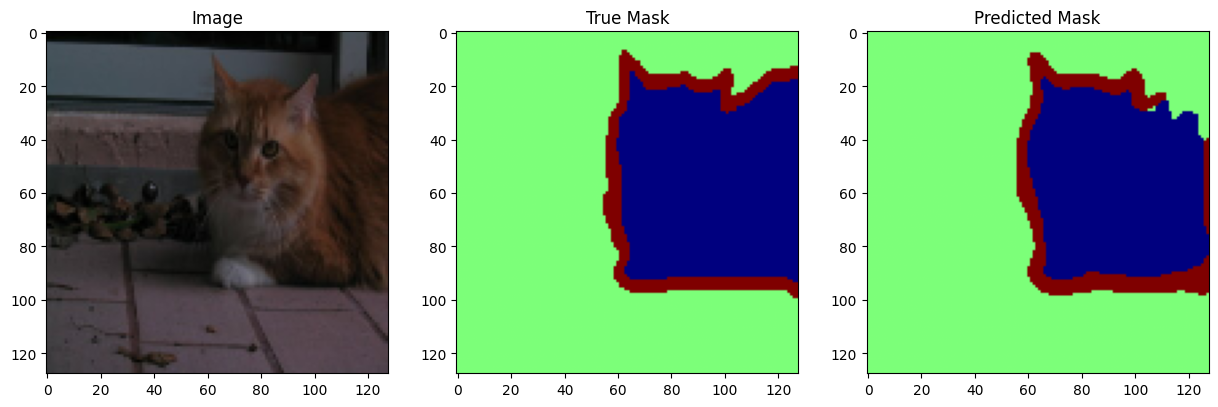

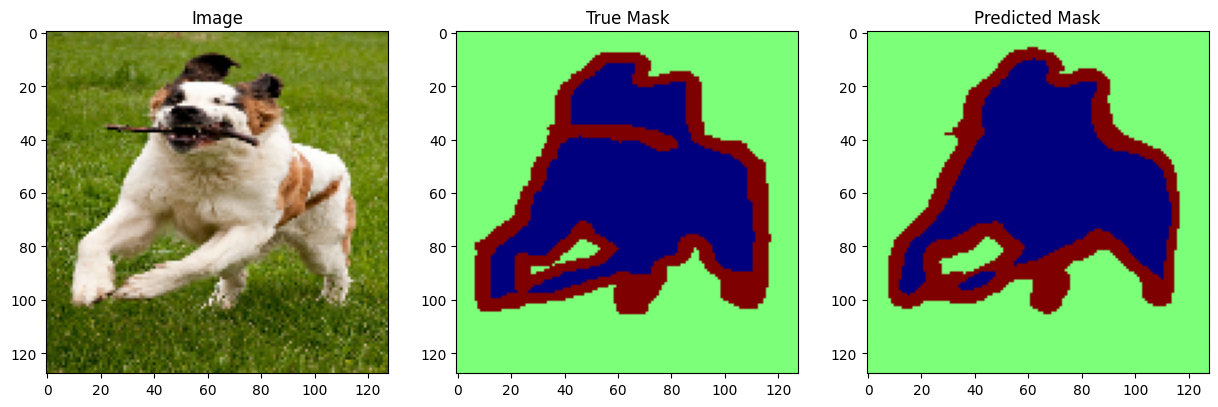

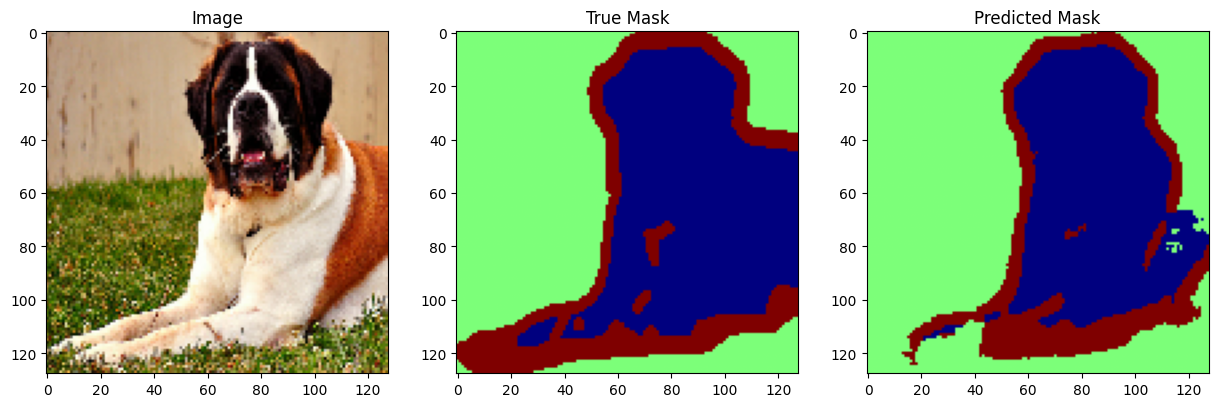

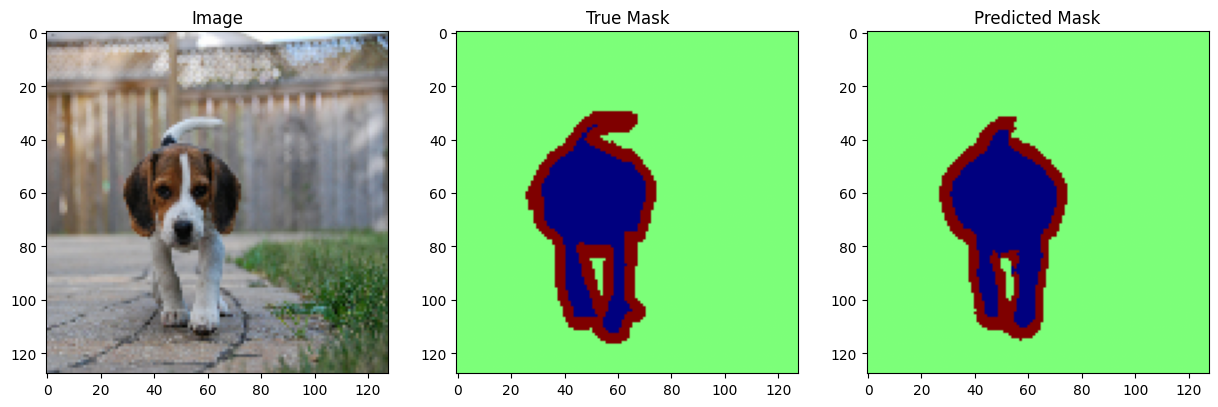

In [ ]:
from tensorflow.keras.metrics import MeanIoU

model = tf.keras.models.load_model('/content/drive/MyDrive/best_unet_oxford_pet_v1.keras')

def compute_iou(y_true, y_pred, num_classes):
    y_pred = tf.argmax(y_pred, axis=-1)
    iou = MeanIoU(num_classes=num_classes)
    iou.update_state(y_true, y_pred)
    return iou.result().numpy()

# Сбор тестовых данных
test_images, test_masks = [], []
for img, mask in test_ds.unbatch():
    test_images.append(img)
    test_masks.append(mask)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Предсказания
y_pred = model.predict(test_images)
iou_score = compute_iou(test_masks, y_pred, num_classes=3)
print("Test IoU:", iou_score)

# Визуализация
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(test_images[i])
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(test_masks[i], cmap='jet')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='jet')
    plt.show()

In [ ]:
def compute_iou_per_class(y_true, y_pred, num_classes):
    y_pred = tf.argmax(y_pred, axis=-1)
    iou_scores = []
    for class_id in range(num_classes):
        iou = MeanIoU(num_classes=2)  # Бинарный IoU для каждого класса
        y_true_binary = tf.cast(y_true == class_id, tf.int32)
        y_pred_binary = tf.cast(y_pred == class_id, tf.int32)
        iou.update_state(y_true_binary, y_pred_binary)
        iou_scores.append(iou.result().numpy())
    return iou_scores

# Сбор тестовых данных (если ещё не сделано)
test_images, test_masks = [], []
for img, mask in test_ds.unbatch():
    test_images.append(img)
    test_masks.append(mask)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Предсказания (если ещё не сделано)
y_pred = model.predict(test_images)

# IoU по классам
iou_per_class = compute_iou_per_class(test_masks, y_pred, num_classes=3)
print("IoU per class:")
print(f"Background (0): {iou_per_class[0]:.4f}")
print(f"Animal (1): {iou_per_class[1]:.4f}")
print(f"Border (2): {iou_per_class[2]:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 66s 576ms/step
IoU per class:
Background (0): 0.8673
Animal (1): 0.8775
Border (2): 0.7132


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      3,584 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │    295,168 │ dropout_5[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ dropout_6[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ dropout_7[0][0] 

 Total params: 367,940,235 (1.37 GB)

 Trainable params: 121,903,363 (465.02 MB)

 Non-trainable params: 2,230,144 (8.51 MB)

 Optimizer params: 243,806,728 (930.05 MB)

# Дообучение (аугментации и разморозка слоев)

In [ ]:
# Загрузка модели
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/best_unet_oxford_pet_v1.keras')
    print("Модель загружена")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")
    raise

# Проверка структуры модели
model.summary()


Модель загружена


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      3,584 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │    295,168 │ dropout_5[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ dropout_6[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ dropout_7[0][0] 

 Total params: 367,940,235 (1.37 GB)

 Trainable params: 121,903,363 (465.02 MB)

 Non-trainable params: 2,230,144 (8.51 MB)

 Optimizer params: 243,806,728 (930.05 MB)

In [ ]:
# Функция preprocess
def preprocess(data, input_size=[128, 128]):
    if not isinstance(data, dict):
        raise ValueError(f"Ожидается словарь, получено: {type(data)}")

    image = data['image']
    mask = data['segmentation_mask']

    tf.debugging.assert_rank(image, 3)
    tf.debugging.assert_rank(mask, 3)

    try:
        image = tf.image.resize(image, input_size, method='bilinear')
        mask = tf.image.resize(mask, input_size, method='nearest')
    except Exception as e:
        print(f"Ошибка в tf.image.resize: {e}")
        raise

    image_shape = tf.shape(image)
    mask_shape = tf.shape(mask)
    tf.debugging.assert_equal(image_shape, tf.constant([128, 128, 3], dtype=tf.int32))
    tf.debugging.assert_equal(mask_shape, tf.constant([128, 128, 1], dtype=tf.int32))

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    mask = tf.clip_by_value(mask, 0, 2)

    try:
        mask = tf.squeeze(mask, axis=-1)
    except Exception as e:
        print(f"Ошибка в tf.squeeze: {e}")
        raise

    mask_shape_squeezed = tf.shape(mask)
    tf.debugging.assert_equal(mask_shape_squeezed, tf.constant([128, 128], dtype=tf.int32))

    return image, mask

# Загрузка и обработка
ds, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])
train_ds, val_ds, test_ds = ds
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


# Сбор данных
train_images, train_masks = [], []
try:
    for i, (img, mask) in enumerate(train_ds.unbatch()):
        img_np = img.numpy()
        mask_np = mask.numpy()
        if img_np.shape != (128, 128, 3) or mask_np.shape != (128, 128):
            print(f"Образец {i}: некорректная форма: img={img_np.shape}, mask={mask_np.shape}")
            continue
        train_images.append(img_np)
        train_masks.append(mask_np)
except Exception as e:
    print(f"Ошибка при сборе данных: {e}")

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Проверка
print("Train images shape:", train_images.shape)
print("Train masks shape:", train_masks.shape)
print("Number of samples:", len(train_images))

# Сохранение
np.save('/content/drive/MyDrive/oxford_pet/train_images_correctstrijd.npy', train_images)
np.save('/content/drive/MyDrive/oxford_pet/train_masks_corrected.npy', train_masks)

Train images shape: (2944, 128, 128, 3)
Train masks shape: (2944, 128, 128)
Number of samples: 2944


In [ ]:
# Сбор валидационных данных
val_images, val_masks = [], []
try:
    for i, (img, mask) in enumerate(val_ds.unbatch()):
        img_np = img.numpy()
        mask_np = mask.numpy()
        if img_np.shape != (128, 128, 3) or mask_np.shape != (128, 128):
            print(f"Валидационный образец {i}: некорректная форма: img={img_np.shape}, mask={mask_np.shape}")
            continue
        val_images.append(img_np)
        val_masks.append(mask_np)
except Exception as e:
    print(f"Ошибка при сборе валидационных данных: {e}")

val_images = np.array(val_images)
val_masks = np.array(val_masks)
print("Val images shape:", val_images.shape)
print("Val masks shape:", val_masks.shape)
print("Number of val samples:", len(val_images))

# Сбор тестовых данных
test_images, test_masks = [], []
try:
    for i, (img, mask) in enumerate(test_ds.unbatch()):
        img_np = img.numpy()
        mask_np = mask.numpy()
        if img_np.shape != (128, 128, 3) or mask_np.shape != (128, 128):
            print(f"Тестовый образец {i}: некорректная форма: img={img_np.shape}, mask={mask_np.shape}")
            continue
        test_images.append(img_np)
        test_masks.append(mask_np)
except Exception as e:
    print(f"Ошибка при сборе тестовых данных: {e}")

test_images = np.array(test_images)
test_masks = np.array(test_masks)
print("Test images shape:", test_images.shape)
print("Test masks shape:", test_masks.shape)
print("Number of test samples:", len(test_images))

# Сохранение
np.save('/content/drive/MyDrive/oxford_pet/val_images_corrected.npy', val_images)
np.save('/content/drive/MyDrive/oxford_pet/val_masks_corrected.npy', val_masks)
np.save('/content/drive/MyDrive/oxford_pet/test_images_corrected.npy', test_images)
np.save('/content/drive/MyDrive/oxford_pet/test_masks_corrected.npy', test_masks)

Val images shape: (736, 128, 128, 3)
Val masks shape: (736, 128, 128)
Number of val samples: 736
Test images shape: (3669, 128, 128, 3)
Test masks shape: (3669, 128, 128)
Number of test samples: 3669


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,  # Увеличено
    width_shift_range=0.15,  # Увеличено
    height_shift_range=0.15,  # Увеличено
    horizontal_flip=True,
    zoom_range=0.1,  # Добавлено
    fill_mode='nearest'
)

# Генератор
def augment_generator(images, masks, batch_size=64):
    if len(images.shape) != 4 or len(masks.shape) != 3:
        raise ValueError(f"Ожидаются формы: images=(num_samples, 128, 128, 3), masks=(num_samples, 128, 128). Получено: images={images.shape}, masks={masks.shape}")
    flow = datagen.flow(
        images,
        masks,
        batch_size=batch_size,
        seed=42
    )
    while True:
        img_batch, mask_batch = next(flow)
        yield img_batch, mask_batch

try:
    train_generator = augment_generator(train_images, train_masks, batch_size=64)
except Exception as e:
    print(f"Ошибка в генераторе: {e}")
    raise

In [ ]:
# Разморозка слоёв
for layer in model.layers:
    layer.trainable = False
for layer in model.layers:
    if 'conv2d_8' in layer.name or 'conv2d_9' in layer.name or 'conv2d_10' in layer.name or 'conv2d_11' in layer.name:
        layer.trainable = True
"""
# Проверка обучаемых слоёв
for layer in model.layers:
    print(f"Layer {layer.name}: trainable = {layer.trainable}")
"""
# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [ ]:
# Коллбэки
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_unet_oxford_pet_v2.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
"""
# Взвешенный лосс через class_weight
class_weights = {0: 1.0, 1: 0.5, 2: 2.0}
"""
# Дообучение
steps_per_epoch = len(train_images) // 32
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
)

# Сохранение истории
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/unet_oxford_pet_history_v2.csv')



Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.6621 - loss: 1.8463 - val_accuracy: 0.6635 - val_loss: 0.9515 - learning_rate: 1.0000e-04
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6422 - loss: 1.0154 - val_accuracy: 0.6809 - val_loss: 0.8652 - learning_rate: 1.0000e-04
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6662 - loss: 0.9029 - val_accuracy: 0.6929 - val_loss: 0.8295 - learning_rate: 1.0000e-04
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6724 - loss: 0.8757 - val_accuracy: 0.7071 - val_loss: 0.7859 - learning_rate: 1.0000e-04
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.6777 - loss: 0.8554 - val_accuracy: 0.7095 - val_loss: 0.7716 - learning_rate: 1.0000e-04
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6835 - loss: 0.8391 - val_accuracy: 0.7163 - val_loss: 0.7541 - learning_rate: 1.0000e-04
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.6856 

In [ ]:
# Подготовка тестовых данных
test_images, test_masks = [], []
for img, mask in test_ds.unbatch():
    test_images.append(img.numpy())
    test_masks.append(mask.numpy())
test_images = np.array(test_images)
test_masks = np.array(test_masks)
print("Test images shape:", test_images.shape)
print("Test masks shape:", test_masks.shape)

# Предсказания
y_pred = model.predict(test_images, batch_size=16)
print("Y_pred shape:", y_pred.shape)

# Расчёт IoU
def compute_iou(y_true, y_pred, num_classes):
    y_pred = tf.argmax(y_pred, axis=-1)
    iou = tf.keras.metrics.MeanIoU(num_classes=num_classes)
    iou.update_state(y_true, y_pred)
    return iou.result().numpy()

def compute_iou_per_class(y_true, y_pred, num_classes):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    iou_scores = []
    for class_id in range(num_classes):
        y_true_binary = tf.cast(y_true == class_id, tf.int32)
        y_pred_binary = tf.cast(y_pred == class_id, tf.int32)
        iou = tf.keras.metrics.MeanIoU(num_classes=2)
        iou.update_state(y_true_binary, y_pred_binary)
        iou_scores.append(iou.result().numpy())
    return iou_scores

iou_score = compute_iou(test_masks, y_pred, num_classes=3)
print("Test IoU:", iou_score)

iou_per_class = compute_iou_per_class(test_masks, y_pred, num_classes=3)
print("IoU per class:")
print(f"Background (0): {iou_per_class[0]:.4f}")
print(f"Animal (1): {iou_per_class[1]:.4f}")
print(f"Border (2): {iou_per_class[2]:.4f}")

# Визуализация
for i in range(5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(test_images[i])
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(test_masks[i], cmap='jet')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='jet')
    plt.savefig(f'/content/drive/MyDrive/oxford_pet_visualization_{i}.png')
    plt.close()

Test images shape: (3669, 128, 128, 3)
Test masks shape: (3669, 128, 128)
230/230 ━━━━━━━━━━━━━━━━━━━━ 99s 345ms/step
Y_pred shape: (3669, 128, 128, 3)
Test IoU: 0.40085733
IoU per class:
Background (0): 0.6301
Animal (1): 0.5787
Border (2): 0.4510
